## Assignment 4
In this assignment you will use spectral decomposition to analyze intracranial data collected during the encoding period of a free recall task (FR1) and will compare spectral power between recalled and not recalled words.

This assignment is designed to familiarize you with time–frequency analysis of intracranial EEG data. For each part of the assignment, you will be using different methods to visualize the subsequent memory effect (SME): the difference in brain signals between study items that are later recalled vs. not recalled.
* Apply a Butterworth notch filter around 60 Hz (freqs = [58 62]) when extracting the voltage.
* Include a 1000ms buffer around time period of interest when computing power; compute power using raw voltage at the original sampling rate
* Log-transform power values

1. Use the first electrode from participant R1111M's data to generate a graph showing the difference in power between subsequently recalled and subsequently not recalled items at the 15 frequencies used above. Provide one time-frequency graph showing average power for Recalled words, another for Not Recalled words, and a third for the difference between the two.
2. Play around with the number of wavelet cycles, frequency, and buffer sizes. What happens as you adjust these parameters?
3. Compute the average time-frequency plot across all temporal cortex electrodes in subject R1111M

Optional:
1. Write your own function to create a complex wavelet
2. Write your own function to convolve two input arrays

In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from CMLLoad import CMLLoad

# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('./CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

765 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


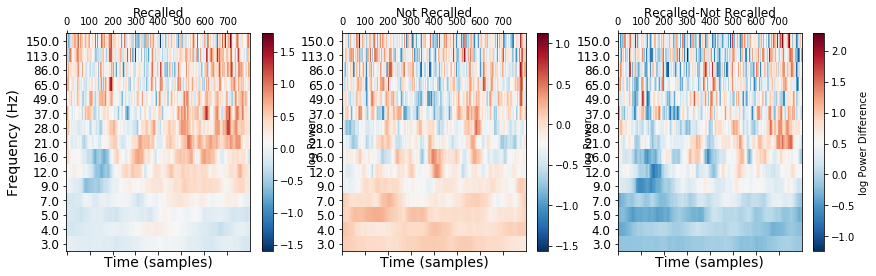

In [2]:
# 1) Recalled vs Not Recalled power

buf = 1000  #define the buffer (in ms) here. Should be at least half the total wavelet length at lowest frequency (i.e. 1/2f * n_cycles). With standard params, 1 sec usually suffices. 

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Pre-define an array of frequencies.
# We can log-space them since wavelets are less sensitive to differences at higher frequencies
myfreqs = np.logspace(np.log10(3), np.log10(150), num=15)

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']

eeg = load.LoadMNE(df_sess, ev_start=-buf, ev_len=buf+1600+buf)
# Select all word events.
eeg = eeg[word_evs.index]
eeg = eeg.pick_channels(eeg.ch_names[0:1])
sr = eeg.info['sfreq'] #we'll need this soon

# spectrum_fit method
filt_data = mne.filter.notch_filter(eeg.get_data(), Fs=eeg.info['sfreq'], freqs=[60, 120],
                                    method='spectrum_fit')

# Run TF decomposition
# Now don't average across events
power = mne.time_frequency.tfr_array_morlet(filt_data, sfreq=sr,freqs=myfreqs, n_cycles=5,output='power')
power_data = np.log10(power[:,0,:,int(buf/1000.*sr):-1*int(buf/1000.*sr)])

# Zscore the data
power_mean = power_data.mean(axis=2, keepdims=True)
m = power_mean.mean(axis=0, keepdims=True)
sd = power_mean.std(axis=0, keepdims=True)
zpower_data = np.squeeze((power_data - m) / sd)
zpower_data.shape

# Separate zscored data into recalled/not recalled events, compute the difference
power_rec = zpower_data[word_evs.recalled==1,:,:]
power_nrec = zpower_data[word_evs.recalled==0,:,:]
power_diff = np.squeeze(np.mean(power_rec,axis=0)-np.mean(power_nrec,axis=0))

# Plot results
plt.figure(figsize=(14., 4))
ax = plt.subplot(131)
plt.matshow(np.mean(power_rec,axis=0), fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.title('Recalled')
cb = plt.colorbar()
cb.set_label('log Power',)

ax = plt.subplot(132)
plt.matshow(np.mean(power_nrec,axis=0), fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.title('Not Recalled')
cb = plt.colorbar()
cb.set_label('log Power',)

ax = plt.subplot(133)
plt.matshow(power_diff, fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.title('Recalled-Not Recalled')
cb = plt.colorbar()
cb.set_label('log Power Difference',)


In [3]:
# 2) Varying the number of wavelet cycles, frequencies, and buffer size
## Student responses will vary.




765 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


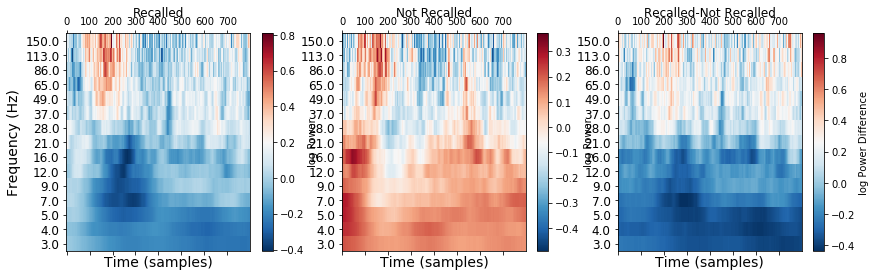

In [4]:
# 3) Average over temporal electrodes

buf = 1000  #define the buffer (in ms) here. Should be at least half the total wavelet length at lowest frequency (i.e. 1/2f * n_cycles). With standard params, 1 sec usually suffices. 

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']

eeg = load.LoadMNE(df_sess, ev_start=-buf, ev_len=buf+1600+buf)
# Select all word events.
eeg = eeg[word_evs.index]

sr = eeg.info['sfreq'] #we'll need this soon
filt_data = mne.filter.notch_filter(eeg.get_data(), Fs=eeg.info['sfreq'], freqs=[60, 120],
                                    method='spectrum_fit')

# Select temporal cortex electrodes
channels = load.Load(df_sess, 'channels')
chan_selector = channels['ind.region'].str.contains('temporal')
filt_data = filt_data[:,chan_selector,:]

# Run TF decomposition
# Now don't average across events
power = mne.time_frequency.tfr_array_morlet(filt_data, sfreq=sr,freqs=myfreqs, n_cycles=5,output='power')
power_data = np.log10(power[:,:,:,int(buf/1000.*sr):-1*int(buf/1000.*sr)])

# Zscore the data
power_mean = power_data.mean(axis=3, keepdims=True)
m = power_mean.mean(axis=0, keepdims=True)
sd = power_mean.std(axis=0, keepdims=True)
zpower_data = np.squeeze((power_data - m) / sd)
zpower_data.shape

# Separate zscored data into recalled/not recalled events, compute the difference
power_rec = zpower_data[word_evs.recalled==1,:,:,:]
power_nrec = zpower_data[word_evs.recalled==0,:,:,:]
power_diff = np.squeeze(np.mean(np.mean(power_rec,axis=0)-np.mean(power_nrec,axis=0),axis=0))

# Plot results
plt.figure(figsize=(14., 4))
ax = plt.subplot(131)
plt.matshow(np.mean(np.mean(power_rec,axis=0),axis=0), fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.title('Recalled')
cb = plt.colorbar()
cb.set_label('log Power',)

ax = plt.subplot(132)
plt.matshow(np.mean(np.mean(power_nrec,axis=0),axis=0), fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.title('Not Recalled')
cb = plt.colorbar()
cb.set_label('log Power',)

ax = plt.subplot(133)
plt.matshow(power_diff, fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.title('Recalled-Not Recalled')
cb = plt.colorbar()
cb.set_label('log Power Difference',)


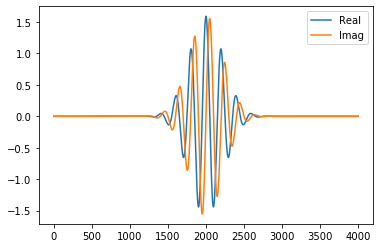

In [5]:
# Optional 1) Function to create a wavelet
def mywavelet(f,n):
    t = np.linspace(-2,2,4000) # set arbitrary t, could scale this with f
    s = n/(2*np.pi*f)
    A = (1/np.sqrt(s*np.sqrt(np.pi)))

    gausspart = A*np.exp((-t**2)/(2*(s**2)))
    
    sinpart = np.exp(1j*2*np.pi*f*t)
    
    wavelet = gausspart*sinpart
    
    return wavelet

f = 5
n = 7
currwave = mywavelet(f,n)
plt.plot(np.real(currwave))
plt.plot(np.imag(currwave))
plt.legend(['Real','Imag'])

In [6]:
# Optional 2) Function for convolution
def myconv(A,B):
    
    lenA = np.size(A)
    lenB = np.size(B)
    C = np.zeros(lenA + lenB - 1)
    
    for m in np.arange(lenA):
        for n in np.arange(lenB):
            C[m+n] = C[m+n] + A[m]*B[n]
    
    return C

# Generate two random timeseries and convolve
a = np.random.randn(10)
b = np.random.randn(5)

c_my = myconv(a,b)
c_py = np.convolve(a,b)

print(np.hstack((c_my[:,None],c_py[:,None])))
c_my.shape

[[ 2.47024892  2.47024892]
 [-0.24026118 -0.24026118]
 [-5.45022235 -5.45022235]
 [ 2.1534175   2.1534175 ]
 [ 3.47038625  3.47038625]
 [-1.28866921 -1.28866921]
 [-1.48773825 -1.48773825]
 [-0.18899255 -0.18899255]
 [ 1.86940572  1.86940572]
 [-0.25133313 -0.25133313]
 [-0.9585002  -0.9585002 ]
 [ 0.79425726  0.79425726]
 [ 0.83912653  0.83912653]
 [ 0.14179498  0.14179498]]


(14,)